### Libraries Used

In [ ]:
!pip install torch torchvision scikit-learn scikit-image scipy pandas matplotlib numpy seaborn opencv-python tabulate ipywidgets joblib tqdm pillow

## Question No. 1


### i.

In [1]:
import glob

image_folder = "./content/patches_256"

# Count files for each specimen
def count_spots(specimen_label):
    file_list = glob.glob(f"{image_folder}/{specimen_label}_*.png")
    return len(file_list)

count_B1 = count_spots("B1")
count_C1 = count_spots("C1")
count_D1 = count_spots("D1")
count_A1 = count_spots("A1")

print(f"Number of spots in B1: {count_B1}")
print(f"Number of spots in C1: {count_C1}")
print(f"Number of spots in D1: {count_D1}")
print(f"Number of spots in A1 (Test set): {count_A1}")

Number of spots in B1: 1800
Number of spots in C1: 4203
Number of spots in D1: 2450
Number of spots in A1 (Test set): 3703


### ii.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fetch the remote protein expression CSV
df = pd.read_csv("https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs909/protein_expression_data.csv")

# Parse 'VisSpot' to isolate which specimen the data originates from.
# Creating a unique 'image_id' will allow us to organise and index the data effectively.
df["specimen_id"] = df["VisSpot"].apply(lambda x: x.split("-")[2])
df["image_id"] = df["specimen_id"] + "_" + df["id"]

# Sort data by 'image_id' for easy referencing and indexing
df = df.set_index("image_id").sort_index()

specimens_list = ["A1", "B1", "C1", "D1"]

# Plot Histograms for CD11b Expression
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for ax, specimen in zip(axes.ravel(), specimens_list):
    subset = df[df["specimen_id"] == specimen]
    ax.hist(subset["CD11b"], bins=30)  # 30 bins chosen arbitrarily for clarity
    ax.set_title(f"CD11b Expression - {specimen}")
    ax.set_xlabel("CD11b Value")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

### iii.

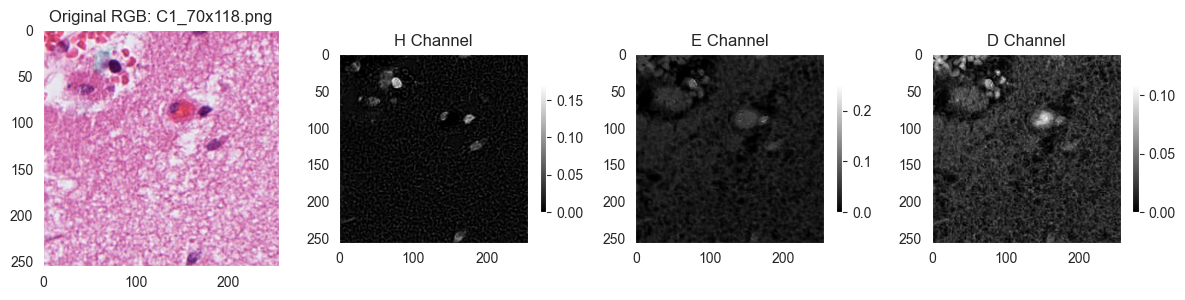

In [3]:
import os
import random
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgba2rgb, rgb2hed

image_folder = "./content/patches_256/"
all_png_files = glob.glob(os.path.join(image_folder, "*.png"))

# Select a small sample of images for demonstration
N = 4
selected_files = random.sample(all_png_files, N)

for img_path in selected_files:
    img = imread(img_path)

    # If the image is RGBA, convert it to RGB
    if img.shape[-1] == 4:
        img_rgb = rgba2rgb(img)
    else:
        img_rgb = img

    # HED decomposition isolates staining components commonly seen in histology
    I_hed = rgb2hed(img_rgb)
    I_h = I_hed[:, :, 0]
    I_e = I_hed[:, :, 1]
    I_d = I_hed[:, :, 2]

    # Present each image alongside its H, E, and D components
    plt.figure(figsize=(12, 3))

    # Original RGB
    plt.subplot(1, 4, 1)
    plt.imshow(img_rgb)
    plt.title(f"Original RGB: {os.path.basename(img_path)}")
    plt.grid(False)

    # H Channel
    plt.subplot(1, 4, 2)
    plt.imshow(I_h, cmap="gray")
    plt.title("H Channel")
    plt.grid(False)
    plt.colorbar(shrink=0.5)

    # E Channel
    plt.subplot(1, 4, 3)
    plt.imshow(I_e, cmap="gray")
    plt.title("E Channel")
    plt.grid(False)
    plt.colorbar(shrink=0.5)

    # D Channel
    plt.subplot(1, 4, 4)
    plt.imshow(I_d, cmap="gray")
    plt.title("D Channel")
    plt.grid(False)
    plt.colorbar(shrink=0.5)

    plt.tight_layout()
    plt.show()

### iv.

In [4]:
import pandas as pd

# Form a unique 'full_image_id' by extracting the third element after splitting 'VisSpot' on '-' and appending '_id'.
df["full_image_id"] = df["VisSpot"].apply(lambda x: x.split("-")[2]) + "_" + df["id"]

full_id_data_path = "./content/protein_expression_data_full_id.csv"

# Writing out to CSV so other steps can read the improved DataFrame
df.to_csv(full_id_data_path, index=False)
print(f"Saved merged CSV to {full_id_data_path}")

Saved merged CSV to ./content/protein_expression_data_full_id.csv


In [5]:
import os
import glob
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.color import rgba2rgb, rgb2hed

# Load the augmented protein expression CSV, which includes 'full_image_id'.
df = pd.read_csv("./content/protein_expression_data_full_id.csv")
image_folder = "./content/patches_256/"

# Accumulate average H-channel measurements in a list of dictionaries.
average_H = []

image_files = glob.glob(os.path.join(image_folder, "*.png"))

for img_path in image_files:
    filename = os.path.basename(img_path).replace(".png", "")
    img = imread(img_path)
    if img.shape[-1] == 4:
        img = rgba2rgb(img)

    # Decompose into HED
    I_hed = rgb2hed(img)
    H_channel = I_hed[:, :, 0]

    # Compute the mean intensity of the H channel as a global measure
    avg_H = np.mean(H_channel)

    average_H.append({"full_image_id": filename,"average_H": avg_H})

# Convert the list of H-channel means to a DataFrame
avgH_df = pd.DataFrame(average_H)

# Merge our new average H-channel values with the existing protein expression data
merged_avgH_df = pd.merge(df, avgH_df, on="full_image_id")

# Exclude rows that lack valid CD11b or average_H values
merged_avgH_df = merged_avgH_df.dropna(subset=["CD11b", "average_H"])

display(merged_avgH_df[["full_image_id", "CD11b", "average_H"]])

full_image_id     CD11b  average_H
0          A1_0x40 -1.445686   0.013534
1          A1_0x42 -1.198798   0.015797
2          A1_0x44 -1.631987   0.015550
3          A1_0x46 -1.922144   0.017684
4          A1_0x48 -0.579756   0.017878
...            ...       ...        ...
9916       D1_9x63 -2.783888   0.022720
9917       D1_9x65 -1.717721   0.029724
9918       D1_9x67 -2.498751   0.031511
9919       D1_9x69 -0.493475   0.029586
9920       D1_9x71 -0.354203   0.028061

[9921 rows x 3 columns]

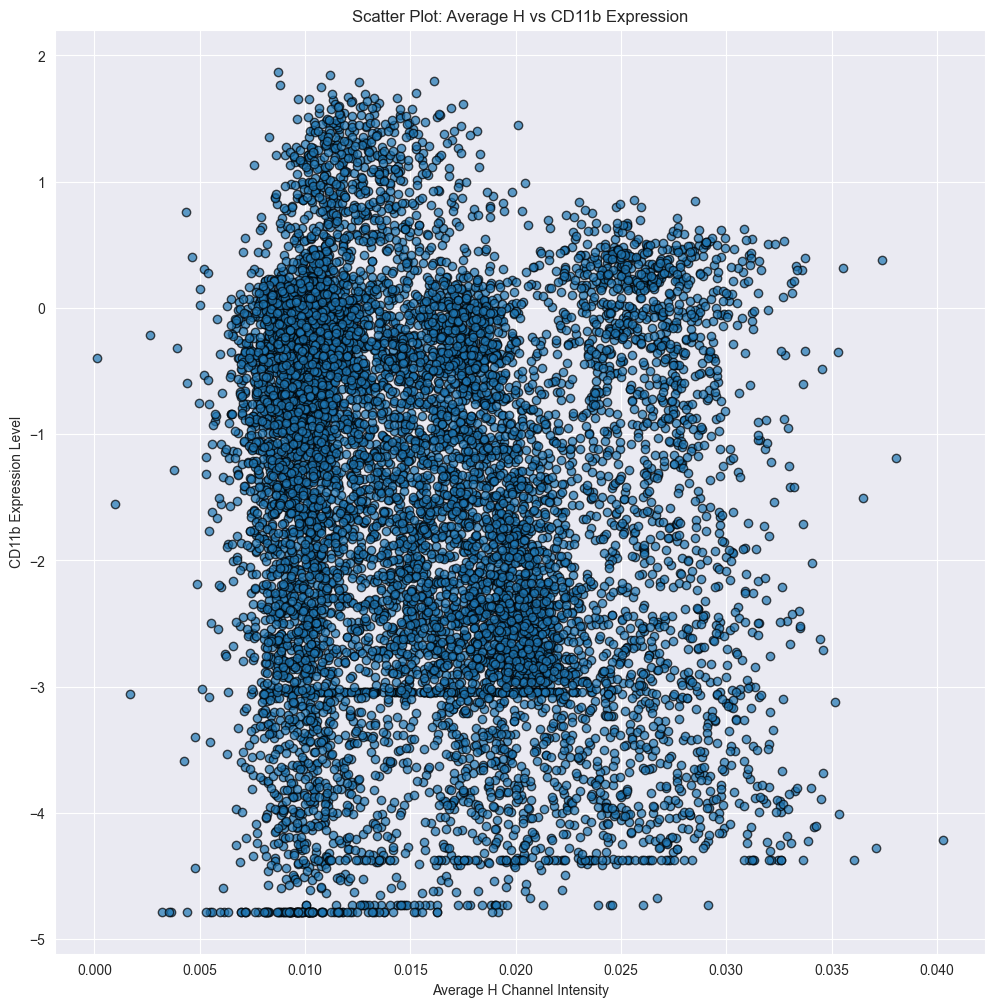

In [6]:
# Scatter plot: Average H vs. CD11b expression
plt.figure(figsize=(12, 12))
plt.scatter(merged_avgH_df['average_H'], merged_avgH_df['CD11b'], alpha=0.7, edgecolor='k')
plt.xlabel('Average H Channel Intensity')
plt.ylabel('CD11b Expression Level')
plt.title('Scatter Plot: Average H vs CD11b Expression')
plt.grid(True)
plt.show()

In [ ]:
from scipy.stats import pearsonr

# Compute Pearson correlation
corr, p_value = pearsonr(merged_avgH_df['average_H'], merged_avgH_df['CD11b'])

# Display correlation results
print(f"Pearson Correlation: {corr:.3f}")
print(f"P-value: {p_value:.3f}")

The scatter plot does not show a clear linear trend between average H-channel intensity and CD11b expression. The Pearson correlation coefficient is -0.157, which indicates a very weak negative correlation. This suggests that as H-channel intensity increases, CD11b expression slightly decreases, but the effect is minimal. The p-value is effectively zero, meaning the correlation is statistically significant. However, statistical significance does not necessarily imply practical significance, as the correlation remains weak.

These results suggest that H-channel intensity, which reflects nuclear density, is not a strong predictor of CD11b expression. CD11b is a marker for immune cells such as macrophages and microglia. If these cells were tightly clustered in areas with high nuclear density, one might expect a stronger positive correlation. However, the weak negative correlation observed suggests that CD11b-positive cells may be more dispersed throughout the tissue, rather than being concentrated in regions with high nuclear density.

Given these findings, it is unlikely that H-channel intensity alone is sufficient for accurately predicting CD11b expression.

### v.

In [7]:
import os
import glob
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.color import rgba2rgb, rgb2hed

df = pd.read_csv("./content/protein_expression_data_full_id.csv")
image_folder = "./content/patches_256/"

# Store the average E-channel intensities in a list of dictionaries
average_E = []

image_files = glob.glob(os.path.join(image_folder, "*.png"))

for img_path in image_files:
    filename = os.path.basename(img_path).replace(".png", "")
    img = imread(img_path)
    if img.shape[-1] == 4:
        img = rgba2rgb(img)

    # Convert to HED space to isolate E (eosin) channel
    I_hed = rgb2hed(img)
    E_channel = I_hed[:, :, 1]

    # Measure the average intensity of the E channel
    avg_E = np.mean(E_channel)

    average_E.append({"full_image_id": filename,"average_E": avg_E})

# Convert the list of eosin intensities to a DataFrame for merging
avgE_df = pd.DataFrame(average_E)

# Merge E-channel intensities with the main protein expression data
merged_avgE_df = pd.merge(df, avgE_df, on="full_image_id")

# Exclude rows missing CD11b or average E-channel values
merged_avgE_df = merged_avgE_df.dropna(subset=["CD11b", "average_E"])

display(merged_avgE_df[["full_image_id", "CD11b", "average_E"]])

full_image_id     CD11b  average_E
0          A1_0x40 -1.445686   0.014727
1          A1_0x42 -1.198798   0.030326
2          A1_0x44 -1.631987   0.035165
3          A1_0x46 -1.922144   0.041112
4          A1_0x48 -0.579756   0.043775
...            ...       ...        ...
9916       D1_9x63 -2.783888   0.014816
9917       D1_9x65 -1.717721   0.025697
9918       D1_9x67 -2.498751   0.027033
9919       D1_9x69 -0.493475   0.026072
9920       D1_9x71 -0.354203   0.024956

[9921 rows x 3 columns]

In [8]:
# Scatter plot: Average E-channel intensity vs CD11b expression
plt.figure(figsize=(12, 12))
plt.scatter(merged_avgE_df['average_E'], merged_avgE_df['CD11b'], alpha=0.7, edgecolor='k')
plt.xlabel('Average E Channel Intensity')
plt.ylabel('CD11b Expression Level')
plt.title('Scatter Plot: Average E vs CD11b Expression')
plt.grid(True)
plt.show()

In [11]:
from scipy.stats import pearsonr

# Compute Pearson correlation
corr_E, p_value_E = pearsonr(merged_avgE_df['average_E'], merged_avgE_df['CD11b'])

# Display correlation results
print(f"Pearson Correlation: {corr_E:.3f}")
print(f"P-value: {p_value_E:.3f}")

Pearson Correlation: 0.223
P-value: 0.000


The Pearson correlation coefficient was calculated as 0.223, which indicates a weak positive correlation. This suggests that there is a slight tendency for images with higher average E-channel intensities to have higher CD11b expression, but the relationship is not particularly strong. The p-value is effectively zero, meaning that this correlation is statistically significant. In other words, the weak positive relationship is unlikely to have occurred by chance.

The weak positive correlation could suggest that CD11b-positive cells are slightly more likely to be found in areas with higher staining, but the low strength of the correlation means this is not a particularly reliable or predictive relationship.

While the E-channel intensity offers some limited predictive value for CD11b expression, the weak correlation implies that it is not a standalone feature that could reliably predict CD11b levels on its own.

### vi.

In [15]:
# Merge the two DataFrames on full_image_id
combined_df = pd.merge(avgH_df, avgE_df, on="full_image_id")

plt.figure(figsize=(12, 12))
plt.scatter(combined_df['average_H'], combined_df['average_E'], alpha=0.7, edgecolor='k')
plt.xlabel('Average H Channel Intensity')
plt.ylabel('Average E Channel Intensity')
plt.title('Scatter Plot: Average H vs Average E Intensity')
plt.grid(True)
plt.show()

In [14]:
from scipy.stats import pearsonr

# Compute Pearson correlation
corr, p_value = pearsonr(combined_df['average_H'], combined_df['average_E'])

# Display correlation results
print(f"Pearson Correlation: {corr:.3f}")
print(f"P-value: {p_value:.3f}")

Pearson Correlation: -0.357
P-value: 0.000


The Pearson correlation coefficient was calculated as -0.357, indicating a moderate negative correlation between these two features. This means that images with higher average H-channel intensity tend to have lower average E-channel intensity.

The implication for modelling is that average H and average E are not redundant features—they capture distinct and complementary aspects of tissue structure. This reinforces the importance of including both channels when designing predictive models for protein expression, as each channel offers unique information about the biological composition of the tissue. Removing either feature results in the loss of valuable information, weakening the model's ability to make accurate predictions as we have seen in the previous examples.

In summary, the moderate negative correlation highlights a meaningful inverse relationship between average H and average blue channel intensities across the image. This supports the case for combining features derived from both the H and E channels when developing predictive models.

### vii.

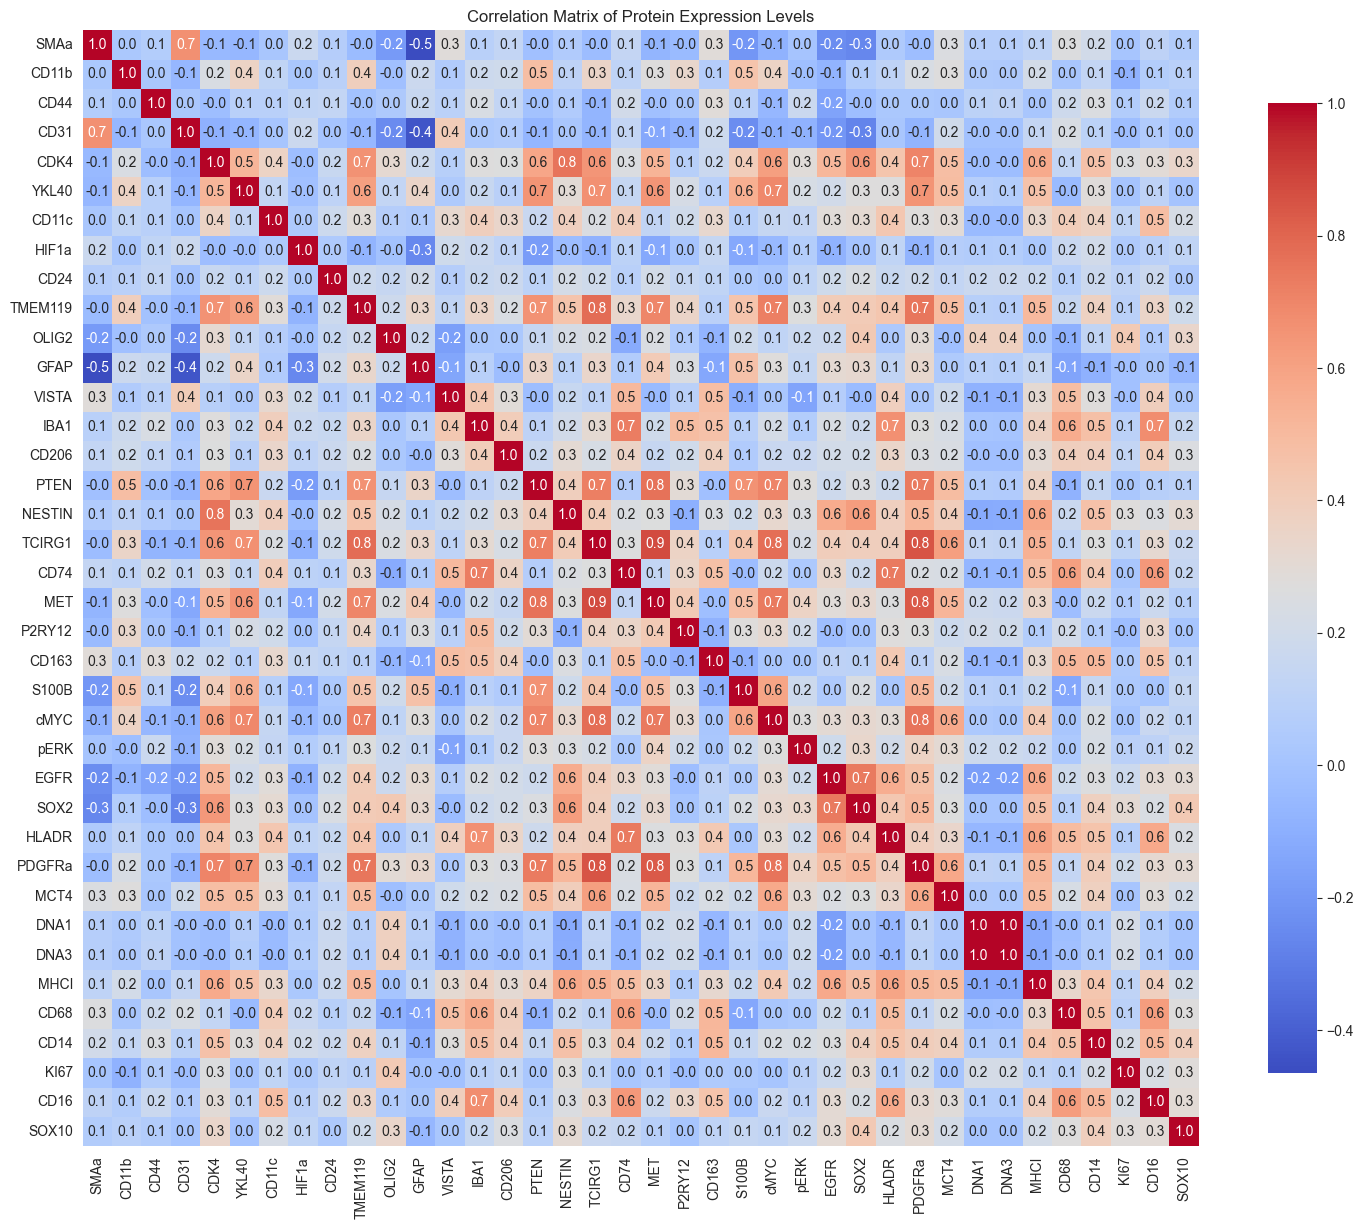

     Protein1 Protein2  Correlation
1208     DNA3     DNA1     0.999114
739       MET   TCIRG1     0.869006
1081   PDGFRa   TCIRG1     0.848205
1083   PDGFRa      MET     0.828382
655    TCIRG1  TMEM119     0.780194
891      cMYC   TCIRG1     0.771311
737       MET     PTEN     0.759903
612    NESTIN     CDK4     0.758211
1087   PDGFRa     cMYC     0.754817
1073   PDGFRa  TMEM119     0.748688


In [16]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("./content/protein_expression_data_full_id.csv")

# Define the target protein columns to study inter-protein correlations
protein_columns = [
    "SMAa", "CD11b", "CD44", "CD31", "CDK4", "YKL40", "CD11c",
    "HIF1a", "CD24", "TMEM119", "OLIG2", "GFAP", "VISTA", "IBA1",
    "CD206", "PTEN", "NESTIN", "TCIRG1", "CD74", "MET", "P2RY12",
    "CD163", "S100B", "cMYC", "pERK", "EGFR", "SOX2", "HLADR",
    "PDGFRa", "MCT4", "DNA1", "DNA3", "MHCI", "CD68", "CD14",
    "KI67", "CD16", "SOX10"
]

# Compute the correlation matrix to see how each protein relates to every other
correlation_matrix = df[protein_columns].corr()

# Visualise the correlation matrix in a heatmap.
plt.figure(figsize=(18, 18))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True,fmt=".1f", square=True, cbar_kws={"shrink": 0.7})
plt.title("Correlation Matrix of Protein Expression Levels")
plt.show()

# Extract the upper triangle only to avoid duplicating mirrored pairs, since correlation matrices are symmetric.
mask_upper = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
correlation_matrix = correlation_matrix.where(mask_upper)

correlation_pairs = correlation_matrix.unstack().reset_index()
correlation_pairs.columns = ["Protein1", "Protein2", "Correlation"]

# Remove missing values
correlation_pairs = correlation_pairs.dropna()

# Compute absolute correlation for sorting so that both strong positive and strong negative relationships float to the top.
correlation_pairs["abs_corr"] = correlation_pairs["Correlation"].abs()
correlation_pairs = correlation_pairs.sort_values(by="abs_corr", ascending=False)

# Display the top ten associations.
top_associations = correlation_pairs.head(10)
print(top_associations[["Protein1", "Protein2", "Correlation"]])

DNA3 and DNA1 have an extremely high correlation of 0.999, which is almost perfect. This suggests that these two measurements are essentially capturing the same biological signal, likely related to total DNA content or similar cellular properties.

Other pairs, such as MET and TCIRG1, PDGFRa and TCIRG1, and PDGFRa and MET, also show very strong positive correlations, all above 0.8. This indicates that these proteins are often expressed together in the same tissue spots. This could reflect shared involvement in the same biological processes.

The consistent appearance of proteins such as TCIRG1, MET, and PDGFRa in these top associations suggests that these proteins may belong to a co-regulated network within the tissue, potentially acting within the same pathways or cellular compartments.

Overall, these results confirm that there are clear associations between certain protein expression levels, particularly within functionally or biologically related groups. This highlights the importance of carefully considering protein relationships when designing predictive models, as strong correlations between predictors can both enhance biological interpretability and create redundancy, depending on the modelling goals.

## Question No. 2

### i.

In [17]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgba2rgb, rgb2hed, rgb2gray
from skimage.feature import hog
from skimage.filters import gabor, sobel
from scipy.stats import entropy
from scipy.ndimage import generic_filter
from concurrent.futures import ThreadPoolExecutor
from sklearn.decomposition import PCA

image_folder = "./content/patches_256/"
df = pd.read_csv("./content/protein_expression_data_full_id.csv")

# Reduce image dimensions to (128, 128) for faster processing at the cost of losing some finer detail
TARGET_SIZE = (128, 128)

# Local variance filter callback for generic_filter.
def local_var(window):
    return np.var(window)

# Pre-cache images to avoid repeated disk reads. (not sure if it is worth it?)
image_cache = {}
filenames = [fn for fn in os.listdir(image_folder) if fn.endswith(".png")]

for filename in tqdm(filenames, desc="Preloading images", ncols=100):
    img_path = os.path.join(image_folder, filename)
    img = imread(img_path)
    # Some images may come with an alpha channel that we convert to RGB
    if img.shape[-1] == 4:
        img = rgba2rgb(img)
    # Resize for consistency and time efficiency
    if img.shape[:2] != TARGET_SIZE:
        img = resize(img, TARGET_SIZE, anti_aliasing=True)
    image_cache[filename] = img

def extract_features(args):
    """
    Extract a suite of colour (HED, RGB), texture (HOG, Gabor, edge density, entropy, local variance),
    and PCA-ready features from the provided image.
    Returns a dictionary of metrics keyed by 'full_image_id'.
    """
    filename, img = args
    full_image_id = filename.replace(".png", "")

    try:
        # Convert RGB to HED to emphasise staining channels
        hed = rgb2hed(img)
        avg_H, var_H = np.mean(hed[:, :, 0]), np.var(hed[:, :, 0])
        avg_E, var_E = np.mean(hed[:, :, 1]), np.var(hed[:, :, 1])
        avg_D, var_D = np.mean(hed[:, :, 2]), np.var(hed[:, :, 2])

        # Extract basic RGB stats to capture colour distribution
        avg_R, var_R = np.mean(img[:, :, 0]), np.var(img[:, :, 0])
        avg_G, var_G = np.mean(img[:, :, 1]), np.var(img[:, :, 1])
        avg_B, var_B = np.mean(img[:, :, 2]), np.var(img[:, :, 2])

        # Convert to greyscale for texture-based descriptors
        img_gray = rgb2gray(img)

        # Histogram of Oriented Gradients (HOG) to capture texture/orientation
        hog_feat = hog(img_gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
        hog_mean = np.mean(hog_feat)

        # Gabor filter for oriented texture analysis
        gabor_feat, _ = gabor(img_gray, frequency=0.6)
        gabor_mean = np.mean(gabor_feat)

        # Sobel edges to measure edge density
        edges = sobel(img_gray)
        edge_density = np.sum(edges > 0.05) / edges.size

        # Image entropy
        hist = np.histogram(img_gray.ravel(), bins=256)[0]
        entropy_value = entropy(hist + 1)  # adding 1 to avoid log(0)

        # Local variance captures how pixel intensity varies in small neighbourhoods
        local_variance = generic_filter(img_gray, local_var, size=11)
        average_local_variance = np.mean(local_variance)

        gradient_x = np.diff(img_gray, axis=1)
        gradient_y = np.diff(img_gray, axis=0)
        avg_gradient_x = np.mean(np.abs(gradient_x))
        avg_gradient_y = np.mean(np.abs(gradient_y))

        # Return a dictionary of the aggregated features
        return {
            "full_image_id": full_image_id,
            "avg_H": avg_H, "var_H": var_H,
            "avg_E": avg_E, "var_E": var_E,
            "avg_D": avg_D, "var_D": var_D,
            "avg_R": avg_R, "var_R": var_R,
            "avg_G": avg_G, "var_G": var_G,
            "avg_B": avg_B, "var_B": var_B,
            "edge_density": edge_density,
            "local_variance": average_local_variance,
            "gradient_x": avg_gradient_x,
            "gradient_y": avg_gradient_y,
            "entropy": entropy_value,
            "hog": hog_mean,
            "gabor": gabor_mean,
            # Normalise greyscale intensities (0..1) for PCA
            "flattened_gray": img_gray.ravel() / 255.0
        }

    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return None

# Parallel feature extraction to accelerate image processing
with ThreadPoolExecutor() as executor:
    results = list(tqdm(
        executor.map(extract_features, image_cache.items()),
        total=len(image_cache),
        desc="Extracting features",
        ncols=100,
        unit="img",
        unit_scale=True
    ))

# Remove any None results
results = [r for r in results if r is not None]

# Convert all feature dictionaries into a DataFrame
features_df = pd.DataFrame(results)

# Apply PCA to the flattened greyscale data for compactness/dimensionality reduction
all_images = np.stack(features_df["flattened_gray"].values)
pca = PCA(n_components=5)
pca_features = pca.fit_transform(all_images)
for i in range(5):
    features_df[f"pca{i+1}"] = pca_features[:, i]

# Having extracted PCA components, we no longer need the flattened grey column
features_df = features_df.drop(columns=["flattened_gray"])

# Merge the newly extracted features with the original protein expression info (CD11b)
merged_features = pd.merge(features_df,df[["full_image_id", "CD11b"]],on="full_image_id")

# Display a random sample
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)
pd.set_option("display.max_rows", 20)
print("\nFinal Extracted Features DataFrame:")
display(merged_features.sample(n=20, random_state=13))

# Save the resulting dataset to CSV for future analysis
output_path = "./content/extracted_features_with_cd11b.csv"
merged_features.to_csv(output_path, index=False)
print(f"Features saved for backup at {output_path}.")

Preloading images: 100%|█████████████████████████████████████| 12156/12156 [01:53<00:00, 107.25it/s]
Extracting features: 100%|████████████████████████████████████| 12.2k/12.2k [24:34<00:00, 8.24img/s]



Final Extracted Features DataFrame:


full_image_id     avg_H     var_H     avg_E     var_E     avg_D     var_D     avg_R     var_R     avg_G     var_G     avg_B     var_B  edge_density  local_variance  gradient_x  gradient_y   entropy       hog     gabor      pca1      pca2      pca3      pca4      pca5     CD11b
7622      C1_68x86  0.009523  0.000147  0.032315  0.000272  0.021450  0.000104  0.830345  0.008798  0.526286  0.028673  0.736316  0.011154      0.712830        0.013640    0.060541    0.063506  5.115488  0.148545  0.039103  0.024173 -0.009604  0.012808  0.010679  0.000344 -2.461831
2804      A1_74x88  0.015345  0.000218  0.034582  0.000271  0.022906  0.000123  0.785848  0.011907  0.482160  0.028500  0.707448  0.012037      0.678528        0.014957    0.055927    0.060210  5.150744  0.149510  0.036322  0.002818  0.007605  0.008526 -0.007320  0.007123  1.067934
7275      C1_62x58  0.007189  0.000140  0.045945  0.000137  0.028681  0.000066  0.816191  0.007091  0.412936  0.009759  0.671624  0.005723      0.552307        0.006805    0.055689    0.050011  4.710468  0.152591  0.033376 -0.020074 -0.002375 -0.002516  0.003877 -0.001132 -0.333889
665      A1_28x108  0.013520  0.000243  0.041058  0.000239  0.026639  0.000083  0.782406  0.012833  0.433483  0.020251  0.676256  0.009590      0.732666        0.014149    0.064991    0.062600  5.103204  0.152712  0.033883 -0.016223  0.003025  0.000552  0.002643 -0.001043 -0.863629
4264     C1_13x115  0.005903  0.000210  0.051510  0.000287  0.054350  0.000718  0.815611  0.012240  0.361186  0.019775  0.543327  0.021995      0.568970        0.011935    0.054246    0.051856  4.924292  0.148737  0.030383 -0.043481  0.010748  0.004554 -0.001438 -0.006332 -4.782092
7992     C1_77x101  0.008342  0.000101  0.035800  0.000108  0.023771  0.000058  0.826815  0.006041  0.483475  0.011552  0.714052  0.005633      0.652222        0.008095    0.064975    0.056589  4.839762  0.152933  0.036975  0.007975  0.000053  0.002166 -0.001400  0.000390 -0.685426
2873       A1_9x45  0.016493  0.000258  0.042406  0.000274  0.027341  0.000086  0.758557  0.013876  0.414689  0.022037  0.662474  0.010833      0.687012        0.013755    0.056259    0.057459  5.198373  0.151039  0.032624 -0.025921 -0.006948 -0.002924  0.001497  0.000879 -1.972085
6689      C1_52x84  0.005138  0.000077  0.044311  0.000078  0.028044  0.000043  0.833171  0.004479  0.427488  0.006385  0.681940  0.003604      0.421631        0.004570    0.046053    0.044702  4.501508  0.154202  0.034329 -0.012653 -0.000249  0.001376  0.001337  0.000531 -0.365614
8550      D1_23x87  0.025751  0.000583  0.034267  0.000332  0.020783  0.000114  0.731619  0.022669  0.459742  0.032253  0.697772  0.015575      0.712646        0.021000    0.058080    0.061476  5.295846  0.146042  0.034499 -0.011375 -0.002432 -0.002890  0.007614  0.003305 -1.304677
7238      C1_61x93  0.008998  0.000142  0.036149  0.000223  0.026263  0.000203  0.821878  0.009159  0.484339  0.021203  0.700938  0.012032      0.755249        0.012219    0.063083    0.069406  5.017252  0.154458  0.036886  0.007222  0.000093 -0.001528 -0.000099  0.003833 -4.261308
4216      C1_12x18  0.011945  0.000188  0.034138  0.000391  0.025307  0.000213  0.804103  0.010304  0.500227  0.037523  0.704154  0.017023      0.632019        0.015013    0.054750    0.056542  5.023045  0.148919  0.037391  0.010700  0.019874  0.013427  0.000361  0.022414 -3.303871
1611      A1_46x66  0.009383  0.000211  0.041337  0.000256  0.028570  0.000097  0.808244  0.011067  0.443698  0.020146  0.674745  0.009714      0.789795        0.014139    0.076695    0.074879  5.018770  0.154542  0.034702 -0.009655  0.002230 -0.000392 -0.000351 -0.003042  0.634911
4116      C1_10x44  0.011098  0.000222  0.043623  0.000233  0.028421  0.000109  0.795685  0.010771  0.420271  0.014798  0.668821  0.008837      0.656311        0.009447    0.052641    0.056131  4.915471  0.153325  0.033420 -0.019897  0.001949  0.004113  0.004883  0.001987 -3.953943
9528      D1_53x69  0.026647  0.000755  0.0

Features saved for backup at ./content/extracted_features_with_cd11b.csv.


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop non-numeric column
numeric_features = merged_features.drop(columns=['full_image_id'])

# Correlation matrix and heatmap
correlation_matrix = numeric_features.corr()

plt.figure(figsize=(14, 14))
sns.heatmap(correlation_matrix, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Feature Correlations (including CD11b)")
plt.show()

 ### ii.

Data Preprocessing Completed.

Training Random Forest

Top 20 Important Features:
       Feature     Importance
5          var_D   0.125715 
3          var_E   0.106156 
6          avg_R   0.095932 
15    gradient_y   0.072679 
4          avg_D   0.067025 
1          var_H   0.038520 
0          avg_H   0.036517 
2          avg_E   0.036322 
14    gradient_x   0.036133 
9          var_G   0.035984 
17          pca1   0.033221 
7          var_R   0.032826 
11         var_B   0.032679 
20          pca4   0.031464 
18          pca2   0.030996 
19          pca3   0.030665 
21          pca5   0.029102 
16       entropy   0.027718 
8          avg_G   0.027152 
12  edge_density   0.025749 

Selected Features for Model Training:
var_D
var_E
avg_R
gradient_y
avg_D
var_H
avg_H
avg_E
gradient_x
var_G
pca1
var_R
var_B
pca4
pca2
Feature Selection Completed.

Hyperparameter Tuning for Random Forest


Fitting Random Forest Model: 100%|██████████| 1/1 [02:59<00:00, 179.54s/it]


Best Random Forest Model Selected.

Hyperparameter Tuning for SVR


Fitting SVR Model: 100%|██████████| 1/1 [00:16<00:00, 16.27s/it]


Best SVR Model Selected.

Training Ordinary Least Squares (OLS) Regression model
OLS Regression model trained.

Evaluating Models

Model Performance Comparison:


Model         RMSE    R² Score  Pearson Correlation  Spearman Correlation
0   Random Forest  1.033250  0.506173       0.714233              0.711517      
1             SVR  1.079098  0.461376       0.684544              0.695019      
2  OLS Regression  1.298247  0.220388       0.470248              0.534022


Saving trained models for future use
Models have been saved successfully.

Generating Scatter Plots


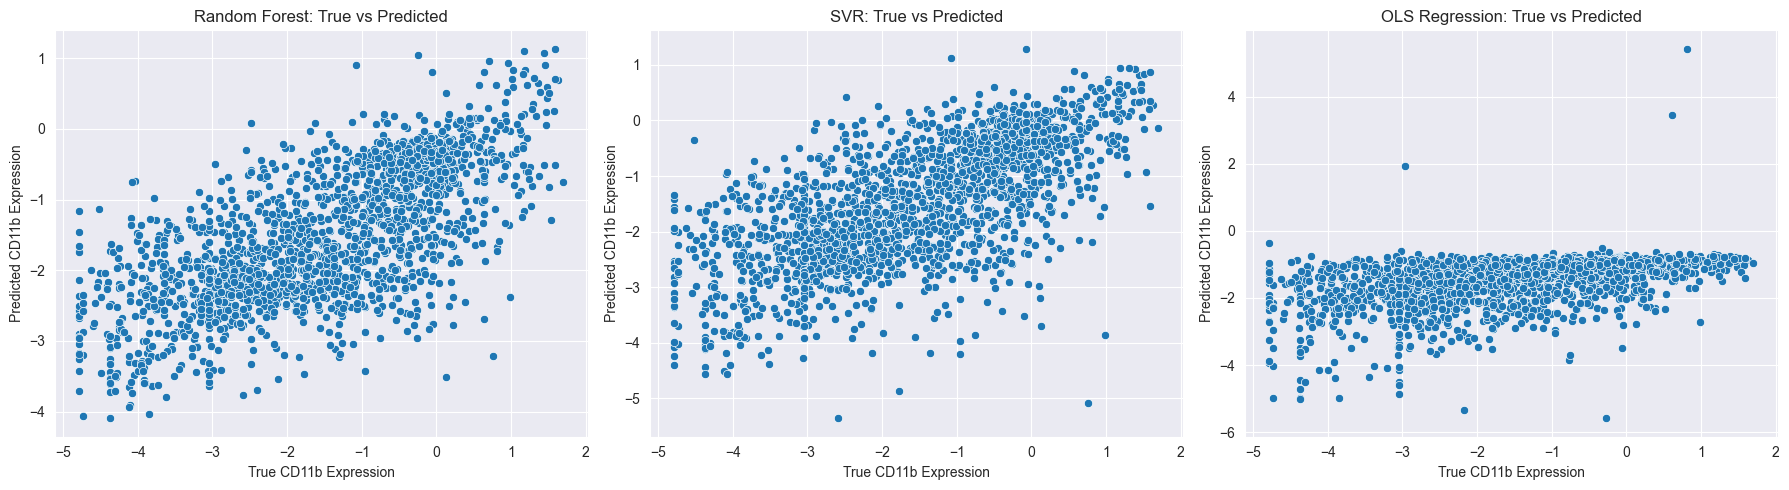

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # Enables model serialisation
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr, pearsonr
from sklearn.linear_model import LinearRegression  # Used for OLS Regression

file_path = "extracted_features_with_cd11b.csv"
df = pd.read_csv(file_path)

# Drop columns not needed for model training
X = df.drop(columns=["full_image_id", "CD11b"])
y = df["CD11b"]

# Standardise features to provide uniform feature scales for regression models
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Remove features that vary too little (below the given threshold), which often do not contribute meaningfully to the model
selector = VarianceThreshold(threshold=0.01)
X_selected = selector.fit_transform(X_scaled)

# Split dataset: set aside 20% as a test set for unbiased performance evaluation
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=13)
print("Data Preprocessing Completed.")

# Temporarily train a Random Forest to identify which features appear most important
print("\nTraining Random Forest")
rf_temp = RandomForestRegressor(n_estimators=100, random_state=13)
rf_temp.fit(X_train, y_train)

# Retrieve and sort feature importances
importances = rf_temp.feature_importances_
feature_names = X.columns[selector.get_support()]
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Display the top 20 features
print("\nTop 20 Important Features:\n", feature_importance_df.head(20))

# Keep only the N most important features and re-train on that subset
N = 15  # Keep the top 15 based on the above analysis
top_features = feature_importance_df.head(N)["Feature"].values

# Filter the dataset to include only these top-ranked features
X_filtered = X[top_features]

# Standardise once more now that the number of features was reduced
X_filtered_scaled = scaler.fit_transform(X_filtered)

# Create a new train/test split with fewer features
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_filtered_scaled, y, test_size=0.2, random_state=13)

# Print the final chosen features
print("\nSelected Features for Model Training:")
for feature in top_features:
    print(feature)
print("Feature Selection Completed.")

# Do cross-validation to find the best hyperparameters for Random Forest
print("\nHyperparameter Tuning for Random Forest")

rf_params = {
    "n_estimators": [200, 500, 800],
    "max_depth": [10, 20, 70],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"]
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=13),
    rf_params,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

# TQDM simply shows a progress bar. Fit once, but it might take time, hence the loop
for _ in tqdm(range(1), desc="Fitting Random Forest Model"):
    rf_grid.fit(X_train_f, y_train_f)

best_rf = rf_grid.best_estimator_
print("Best Random Forest Model Selected.")

print("\nHyperparameter Tuning for SVR")
svr_params = {
    "C": [1, 10],
    "epsilon": [0.01, 0.1],
    "kernel": ["rbf", "poly"],
    "gamma": ["scale"]
}

svr_grid = GridSearchCV(
    SVR(),
    svr_params,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

for _ in tqdm(range(1), desc="Fitting SVR Model"):
    svr_grid.fit(X_train_f, y_train_f)

best_svr = svr_grid.best_estimator_
print("Best SVR Model Selected.")

# Train an OLS Regression
print("\nTraining Ordinary Least Squares (OLS) Regression model")
ols_model = LinearRegression()
ols_model.fit(X_train_f, y_train_f)
print("OLS Regression model trained.")

# Evaluate each model on the test set, computing RMSE, R², Pearson, and Spearman correlation
print("\nEvaluating Models")

# Make predictions on the withheld test data
y_pred_rf = best_rf.predict(X_test_f)
y_pred_svr = best_svr.predict(X_test_f)
y_pred_ols = ols_model.predict(X_test_f)

def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    pearson_corr, _ = pearsonr(y_true, y_pred)
    spearman_corr, _ = spearmanr(y_true, y_pred)

    return {"Model": model_name,"RMSE": rmse,"R² Score": r2,"Pearson Correlation": pearson_corr,"Spearman Correlation": spearman_corr}

# Generate performance metrics for each model
results_rf = evaluate_model(y_test_f, y_pred_rf, "Random Forest")
results_svr = evaluate_model(y_test_f, y_pred_svr, "SVR")
results_ols = evaluate_model(y_test_f, y_pred_ols, "OLS Regression")

# Compare models in a DataFrame
results_df = pd.DataFrame([results_rf, results_svr, results_ols])

print("\nModel Performance Comparison:")
display(results_df)

# Storing the final models for future usage or deployment
print("\nSaving trained models for future use")

os.makedirs("./models", exist_ok=True)
joblib.dump(best_rf, "./models/random_forest_model.pkl")
joblib.dump(best_svr, "./models/svr_model.pkl")
joblib.dump(ols_model, "./models/ols_regression_model.pkl")

print("Models have been saved successfully.")

# Generate scatter plots of the test set results to visualise how well models predict
print("\nGenerating Scatter Plots")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Random Forest scatter
sns.scatterplot(x=y_test_f, y=y_pred_rf, ax=axes[0])
axes[0].set_title("Random Forest: True vs Predicted")
axes[0].set_xlabel("True CD11b Expression")
axes[0].set_ylabel("Predicted CD11b Expression")

# SVR scatter
sns.scatterplot(x=y_test_f, y=y_pred_svr, ax=axes[1])
axes[1].set_title("SVR: True vs Predicted")
axes[1].set_xlabel("True CD11b Expression")
axes[1].set_ylabel("Predicted CD11b Expression")

# OLS scatter
sns.scatterplot(x=y_test_f, y=y_pred_ols, ax=axes[2])
axes[2].set_title("OLS Regression: True vs Predicted")
axes[2].set_xlabel("True CD11b Expression")
axes[2].set_ylabel("Predicted CD11b Expression")

plt.tight_layout()
plt.show()

Root Mean Squared Error (RMSE) is the most appropriate single metric for this prediction problem. It directly measures the average magnitude of errors in the same scale as the target variable and penalizes large deviations more heavily due to the squaring operation, making it highly interpretable for continuous regression tasks.

Even though RMSE is well-suited as a single metric, combining multiple metrics (like R², Pearson correlation, or Spearman correlation) provides a fuller picture of overall model performance.

## Question No. 3

### i.

In [15]:
import os
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import mean_squared_error, r2_score  # missing in original snippet
from skimage.color import rgba2rgb

# ImageNet mean and standard deviation for normalisation
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Data augmentation transforms: random flips, rotations, etc.
# helps the model avoid overfitting certain orientations or lighting.
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# Minimal transform for validation: resize & normalise
basic_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

class CD11bDataset(Dataset):
    def __init__(self, image_folder, csv_file, feature_file, specimens=None,
                 transform=None, use_features=True):
        self.image_folder = image_folder
        self.transform = transform
        self.use_features = use_features

        # Read the CSV containing protein expression, focusing on CD11b
        self.df = pd.read_csv(csv_file)
        self.df.columns = self.df.columns.str.strip()

        # Restrict to chosen specimens if specified (for train/val splits)
        if specimens is not None:
            self.df = self.df[self.df["specimen_id"].isin(specimens)]

        # Map each image filename to its respective CD11b expression
        self.image_targets = {
            f"{row['full_image_id']}.png": row["CD11b"] for _, row in self.df.iterrows()
        }

        # Load the extracted handcrafted features from a separate CSV
        self.feature_df = pd.read_csv(feature_file)
        self.feature_df.columns = self.feature_df.columns.str.strip()
        if "full_image_id" not in self.feature_df.columns:
            raise KeyError("Missing 'full_image_id' column in extracted feature file.")

        # Collect valid feature columns
        valid_features = [col for col in self.feature_df.columns if col != "full_image_id"]
        self.num_features = len(valid_features)

        # Map each filename to its feature vector
        self.feature_dict = {
            f"{row['full_image_id']}.png": row.iloc[1:].astype(np.float32).values
            for _, row in self.feature_df.iterrows()
        }

        # Gather all relevant image filenames that match the CSV
        self.filenames = [
            fn for fn in os.listdir(self.image_folder)
            if fn.endswith(".png") and fn in self.image_targets
        ]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fn = self.filenames[idx]
        img_path = os.path.join(self.image_folder, fn)
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image {img_path} not found.")

        # Load the image and convert to RGB (in case of RGBA)
        img = Image.open(img_path).convert("RGB")

        # Apply transforms (augmentation or basic)
        if self.transform:
            img = self.transform(img)

        # Target expression for CD11b
        target = torch.tensor(self.image_targets[fn], dtype=torch.float32).unsqueeze(0)

        # Include additional handcrafted features if requested
        if self.use_features:
            features = torch.tensor(self.feature_dict[fn], dtype=torch.float32)
            return img, features, target
        else:
            return img, target

class CD11bCNNWithFeatures(nn.Module):
    """
    CNN architecture extracting image features, then concatenates
    these with additional handcrafted features before regression.
    """
    def __init__(self, num_features):
        super().__init__()

        # Convolutional feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # consistent output size
        )

        # The flattened CNN output is size 512
        self.flattened_dim = 512

        # Final layer to combine CNN features + handcrafted features
        self.classifier = nn.Sequential(
            nn.Linear(self.flattened_dim + num_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 1)
        )

    def forward(self, x, features):
        # Extract deep CNN features
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)

        # Confirm handcrafted features have correct dimensionality
        expected_feat_dim = self.classifier[0].in_features - self.flattened_dim
        if features.shape[1] != expected_feat_dim:
            raise ValueError(f"Feature shape mismatch! Expected {expected_feat_dim}, got {features.shape[1]}")

        # Concatenate image-based features with numeric handcrafted features
        x = torch.cat((x, features), dim=1)
        return self.classifier(x)


def train_model(model, train_loader, val_loader, device, num_epochs=10, patience=10):
    """
    Trains the model with a log-cosh loss for robustness to outliers,
    using a cosine annealing scheduler to vary the learning rate.
    We now consistently save the best model as 'best_single_protein.pth'.
    """
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=10)

    def log_cosh_loss(preds, targets):
        return torch.mean(torch.log(torch.cosh(preds - targets + 1e-12)))

    criterion = log_cosh_loss

    best_val_loss = float("inf")
    os.makedirs("./models", exist_ok=True)

    from sklearn.metrics import mean_squared_error, r2_score

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss_sum = 0.0

        for images, features, targets in train_loader:
            images, features, targets = images.to(device), features.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(images, features)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss_sum += loss.item()

        avg_train_loss = train_loss_sum / len(train_loader)

        # Validation
        model.eval()
        val_loss_sum = 0.0
        all_truths, all_preds = [], []

        with torch.no_grad():
            for images, features, targets in val_loader:
                images, features, targets = images.to(device), features.to(device), targets.to(device)
                outputs = model(images, features)
                val_loss_sum += criterion(outputs, targets).item()

                all_truths.extend(targets.cpu().numpy().flatten())
                all_preds.extend(outputs.cpu().numpy().flatten())

        avg_val_loss = val_loss_sum / len(val_loader)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        scheduler.step()

        # Save the best model whenever validation improves
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            model_save_path = "./models/best_single_protein.pkl"
            torch.save(model.state_dict(), model_save_path)
            print(f"Saved best model at epoch {epoch+1} with Val Loss {avg_val_loss:.4f}\n")

    return model


if __name__ == "__main__":
    image_folder = "./content/patches_256/"
    csv_file = "./content/protein_expression_data_full_id.csv"
    feature_file = "./content/extracted_features_with_cd11b.csv"

    # Decide which specimens go to training vs. validation
    train_specs = ["B1", "C1", "D1"]
    val_specs = ["A1"]

    train_dataset = CD11bDataset(
        image_folder=image_folder,
        csv_file=csv_file,
        feature_file=feature_file,
        specimens=train_specs,
        transform=augmentation
    )
    val_dataset = CD11bDataset(
        image_folder=image_folder,
        csv_file=csv_file,
        feature_file=feature_file,
        specimens=val_specs,
        transform=basic_transforms
    )

    num_features = train_dataset.num_features

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Instantiate and train the model
    model = CD11bCNNWithFeatures(num_features)
    trained_model = train_model(model, train_loader, val_loader, device)

Epoch 1/10
Train Loss: 0.2470 | Val Loss: 0.0258
Saved best model at epoch 1 with Val Loss 0.0258

Epoch 2/10
Train Loss: 0.1282 | Val Loss: 0.0738
Epoch 3/10
Train Loss: 0.1157 | Val Loss: 0.0883
Epoch 4/10
Train Loss: 0.1022 | Val Loss: 0.0137
Saved best model at epoch 4 with Val Loss 0.0137

Epoch 5/10
Train Loss: 0.0913 | Val Loss: 0.0136
Saved best model at epoch 5 with Val Loss 0.0136

Epoch 6/10
Train Loss: 0.0924 | Val Loss: 0.0064
Saved best model at epoch 6 with Val Loss 0.0064

Epoch 7/10
Train Loss: 0.0858 | Val Loss: 0.0207
Epoch 8/10
Train Loss: 0.0826 | Val Loss: 0.0097
Epoch 9/10
Train Loss: 0.0795 | Val Loss: 0.0258
Epoch 10/10
Train Loss: 0.0835 | Val Loss: 0.0147


RMSE: 0.1726
R² Score: 0.9856
Pearson Correlation: 0.9988
Spearman Correlation: 0.9983


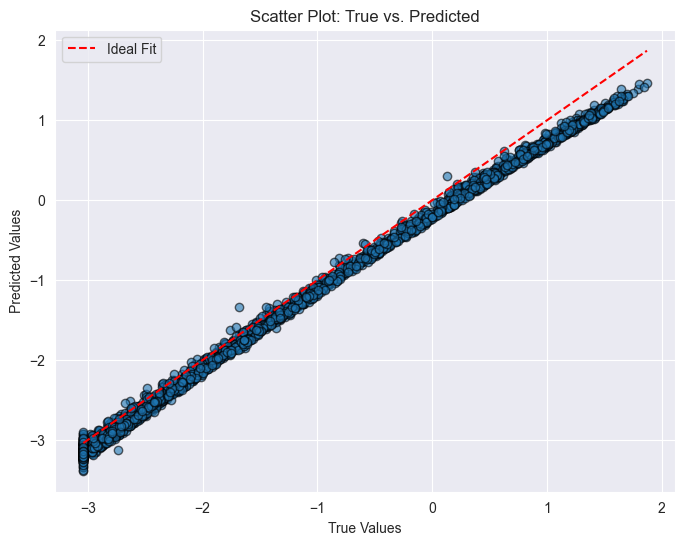

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr

# Define the test dataset to assess final performance on unseen data
test_dataset = CD11bDataset(
    image_folder=image_folder,
    csv_file=csv_file,
    feature_file=feature_file,
    specimens=["A1"],
    transform=basic_transforms
)

# Avoid shuffling for the test loader to preserve data ordering
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()

# Lists to store ground truth and predictions for final metric calculations
true_values = []
predictions = []

# Do not require gradients for inference
with torch.no_grad():
    for images, features, targets in test_loader:
        images, features, targets = images.to(device), features.to(device), targets.to(device)
        outputs = model(images, features)

        # Collect the real and predicted values for performance metrics
        true_values.extend(targets.cpu().numpy().flatten())
        predictions.extend(outputs.cpu().numpy().flatten())

# Convert lists to NumPy arrays for numerical operations
true_values = np.array(true_values)
predictions = np.array(predictions)

# Standard metrics to judge regression performance
rmse = np.sqrt(mean_squared_error(true_values, predictions))
r2 = r2_score(true_values, predictions)
pearson_corr, _ = pearsonr(true_values, predictions)
spearman_corr, _ = spearmanr(true_values, predictions)

results_single_cnn = {
    "Model": "Single-Protein CNN",
    "RMSE": rmse,
    "R² Score": r2,
    "Pearson Correlation": pearson_corr,
    "Spearman Correlation": spearman_corr
}

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"Spearman Correlation: {spearman_corr:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(true_values, predictions, alpha=0.6, edgecolors='k')
plt.plot([min(true_values), max(true_values)],[min(true_values), max(true_values)],'--r', label="Ideal Fit")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Scatter Plot: True vs. Predicted")
plt.legend()
plt.grid(True)
plt.show()

### ii.

In [5]:
import os
import gc
import torch
import numpy as np
import pandas as pd
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import torchvision.models as models
from torchvision.models import ResNet50_Weights
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr


# Configuration / Hyperparameters
num_epochs = 20
batch_size = 32
learning_rate = 1e-4
target_image_size = (224, 224)
specimens = ["A1", "B1", "C1", "D1"]
expected_protein_columns = [
    "CD11b", "CD44", "CD31", "CDK4", "YKL40", "CD11c", "HIF1a", "CD24", "TMEM119",
    "OLIG2", "GFAP", "VISTA", "IBA1", "CD206", "PTEN", "NESTIN", "TCIRG1", "CD74",
    "MET", "P2RY12", "CD163", "S100B", "cMYC", "pERK", "EGFR", "SOX2", "HLADR",
    "PDGFRa", "MCT4", "DNA1", "DNA3", "MHCI", "CD68", "CD14", "KI67", "CD16"
]

# Data Augmentation & Preprocessing
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

basic_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# Dataset for Multi-Target Regression
class ProteinExpressionDatasetMulti(Dataset):
    """
    Loads images and multiple protein expression values. We convert
    images to numpy arrays, possibly resize them, then transform them
    for use in a CNN. All references to Neptune or TQDM are removed.
    """
    def __init__(self, image_folder, csv_file, specimens=None,
                 target_size=(224, 224), transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.target_size = target_size

        # Load CSV data and filter by requested specimens
        self.df = pd.read_csv(csv_file)
        if specimens is not None:
            self.df = self.df[self.df["specimen_id"].isin(specimens)]

        # Identify relevant protein columns
        self.protein_columns = [
            col for col in expected_protein_columns
            if col in self.df.columns
        ]
        self.num_proteins = len(self.protein_columns)

        # Create a dictionary mapping each filename to the relevant protein array
        self.image_targets = {
            f"{row['full_image_id']}.png": np.array(
                [row[col] for col in self.protein_columns], dtype=np.float32
            )
            for _, row in self.df.iterrows()
        }

        self.image_cache = {}
        self.filenames = self._load_images()

    def _load_images(self):
        """
        Load images from disk into a cache to avoid repeated IO.
        """
        filenames = []
        for filename in os.listdir(self.image_folder):
            if filename.endswith(".png"):
                img_path = os.path.join(self.image_folder, filename)
                img = imread(img_path)

                # Convert RGBA -> RGB
                if img.ndim == 3 and img.shape[-1] == 4:
                    img_pil = Image.fromarray(img).convert("RGB")
                    img = np.array(img_pil)

                # Resize for consistent input dimensions
                if img.shape[:2] != self.target_size:
                    img = resize(img, self.target_size, anti_aliasing=True)

                self.image_cache[filename] = img
                filenames.append(filename)

        # Include only filenames found in the CSV mapping
        valid_fns = [fn for fn in filenames if fn in self.image_targets]
        return valid_fns

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fn = self.filenames[idx]
        img = self.image_cache[fn]
        target = self.image_targets[fn]

        # Convert to uint8 if needed, then apply transforms for the CNN
        if self.transform:
            if img.dtype != np.uint8:
                img = (img * 255).astype(np.uint8)
            pil_img = Image.fromarray(img)
            img = self.transform(pil_img)
        else:
            # Fallback: convert numpy array to Torch tensor
            img = torch.tensor(img).permute(2, 0, 1).float()

        # Final target vector with multiple protein columns
        target = torch.tensor(target).float()
        return img, target

# ResNet50 for Multi-Target Regression
class ResNet50Multi(nn.Module):
    """
    Adapt the standard ResNet50 architecture to output a vector of size 'num_outputs' for multi-target regression.
    """
    def __init__(self, num_outputs):
        super(ResNet50Multi, self).__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        in_features = self.resnet.fc.in_features
        # Replace the final classification layer with a new linear layer
        # for multi-target regression
        self.resnet.fc = nn.Linear(in_features, num_outputs)

    def forward(self, x):
        return self.resnet(x)

# Training and Evaluation
def train_model(model, train_loader, device, num_epochs=20):
    model.to(device)
    optimiser = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    epoch_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, targets in train_loader:
            images, targets = images.to(device), targets.to(device)
            optimiser.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimiser.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {epoch_loss:.4f}")

    return model, epoch_losses

@torch.no_grad()
def evaluate_model(model, loader, device):
    """
    Evaluates the model on a loader, collating all predictions and targets for subsequent metric calculations (RMSE, Pearson, etc.).
    """
    model.eval()
    all_preds = []
    all_true = []

    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)
        all_preds.append(outputs.cpu().numpy())
        all_true.append(targets.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_true = np.concatenate(all_true, axis=0)
    return all_preds, all_true

def compute_per_protein_metrics(y_true, y_pred, protein_names):
    """
    For each protein, compute RMSE, R², Pearson, Spearman.
    Return a list of dicts for easy DataFrame conversion.
    """
    num_proteins = y_true.shape[1]
    metrics_list = []
    for i in range(num_proteins):
        true_vals = y_true[:, i]
        pred_vals = y_pred[:, i]
        mse_val = mean_squared_error(true_vals, pred_vals)
        rmse_val = np.sqrt(mse_val)
        r2_val = r2_score(true_vals, pred_vals)
        pear_corr, _ = pearsonr(true_vals, pred_vals)
        spear_corr, _ = spearmanr(true_vals, pred_vals)
        metrics_list.append({
            "Protein": protein_names[i],
            "RMSE": rmse_val,
            "R2": r2_val,
            "Pearson": pear_corr,
            "Spearman": spear_corr
        })
    return metrics_list

# Leave-One-Specimen-Out Cross-Validation
if __name__ == "__main__":
    image_folder = "./content/patches_256/"
    csv_file = "./content/protein_expression_data_full_id.csv"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the main CSV to identify the final list of protein columns
    df = pd.read_csv(csv_file)
    protein_names = [col for col in expected_protein_columns if col in df.columns]

    fold_metrics = []

    for test_specimen in specimens:
        train_specimens = [s for s in specimens if s != test_specimen]
        print(f"\nFold: Training on {train_specimens}, Testing on {test_specimen}")

        # Create datasets and loaders
        train_dataset = ProteinExpressionDatasetMulti(
            image_folder, csv_file, specimens=train_specimens,
            target_size=(112, 112), transform=basic_transforms
        )
        test_dataset = ProteinExpressionDatasetMulti(
            image_folder, csv_file, specimens=[test_specimen],
            target_size=(112, 112), transform=basic_transforms
        )

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Instantiate ResNet50-based model for multi-target regression
        num_proteins = train_dataset.num_proteins
        model = ResNet50Multi(num_outputs=num_proteins)
        trained_model, epoch_losses = train_model(model, train_loader, device, num_epochs=num_epochs)

        # Evaluate on the test set
        preds, truths = evaluate_model(trained_model, test_loader, device)
        fold_protein_metrics = compute_per_protein_metrics(truths, preds, protein_names)

        # Store each protein's metrics, tagging them by test specimen
        for metric_dict in fold_protein_metrics:
            metric_dict["Test_Specimen"] = test_specimen

        fold_metrics.extend(fold_protein_metrics)

        # Save the model for each fold
        torch.save(trained_model.state_dict(), f"./models/resnet50_multi_fold_{test_specimen}.pkl")

        # Clean up to free memory
        del train_dataset, test_dataset, train_loader, test_loader, model, preds, truths
        gc.collect()

    # Convert the collected fold_metrics to a DataFrame
    metrics_df = pd.DataFrame(fold_metrics)
    print("\nPer-fold per-protein metrics:")
    print(metrics_df)

    # Aggregate metrics by taking mean & std for each protein
    results_multi_cnn = metrics_df.groupby("Protein").agg({
        "RMSE": ["mean", "std"],
        "R2": ["mean", "std"],
        "Pearson": ["mean", "std"],
        "Spearman": ["mean", "std"]
    }).reset_index()

    # Flatten multi-index columns for readability
    results_multi_cnn.columns = [
        "_".join(col) if isinstance(col, tuple) else col
        for col in results_multi_cnn.columns
    ]

    print("\nConsolidated metrics per protein (mean ± std):")
    print(results_multi_cnn)

    # Count how many proteins have average Spearman > 0.7
    num_proteins_above_07 = (results_multi_cnn["Spearman_mean"] > 0.7).sum()
    print(f"\nNumber of proteins with average Spearman above 0.7: {num_proteins_above_07}")


Fold: Training on ['B1', 'C1', 'D1'], Testing on A1
Epoch 1/20 - Training Loss: 0.9383
Epoch 2/20 - Training Loss: 0.5765
Epoch 3/20 - Training Loss: 0.4707
Epoch 4/20 - Training Loss: 0.4072
Epoch 5/20 - Training Loss: 0.3552
Epoch 6/20 - Training Loss: 0.3053
Epoch 7/20 - Training Loss: 0.2638
Epoch 8/20 - Training Loss: 0.2296
Epoch 9/20 - Training Loss: 0.2027
Epoch 10/20 - Training Loss: 0.1741
Epoch 11/20 - Training Loss: 0.1563
Epoch 12/20 - Training Loss: 0.1385
Epoch 13/20 - Training Loss: 0.1237
Epoch 14/20 - Training Loss: 0.1133
Epoch 15/20 - Training Loss: 0.1014
Epoch 16/20 - Training Loss: 0.0952
Epoch 17/20 - Training Loss: 0.0860
Epoch 18/20 - Training Loss: 0.0777
Epoch 19/20 - Training Loss: 0.0741
Epoch 20/20 - Training Loss: 0.0673

Fold: Training on ['A1', 'C1', 'D1'], Testing on B1
Epoch 1/20 - Training Loss: 0.9110
Epoch 2/20 - Training Loss: 0.5803
Epoch 3/20 - Training Loss: 0.4875
Epoch 4/20 - Training Loss: 0.4150
Epoch 5/20 - Training Loss: 0.3583
Epoch 6/

### iii.

**A**

Location data could be valuable because tissue specimens often exhibit spatial patterns where neighbouring spots share similar staining, cell density, or microenvironmental factors. By adding spot coordinates or grouping neighbouring patches, the model can capture these local variations that might not be apparent from individual patches alone. For instance, including segmentations of the tissue type or tumour regions could further refine the prediction.

If the images are part of a larger spatial mosaic, we can take advantage of these coordinates.

**B**

If a predictor depends mainly on a few highly correlated proteins, it might be reflecting surrogate markers rather than genuinely learning to predict CD11b. The simplest checks involve removing or masking those correlated protein columns and checking whether the model’s performance deteriorates. If performance drops substantially, then the model is over-reliant on those proteins rather than discovering any new pattern tied specifically to CD11b. Another check is partial correlation, which can test whether the predictor remains strongly correlated with CD11b once other proteins are accounted for.

If the model is not independent of correlated proteins, its usefulness may be limited to contexts where those correlations hold. In new datasets or different biological conditions where the relationships between proteins change, prediction accuracy might degrade. Therefore, a more reliable approach is to gather a broader dataset spanning diverse specimens and conditions, use dimensionality reduction or regularisation to mitigate overfitting, and incorporate domain knowledge to interpret whether the observed correlations are meaningful or merely incidental.

## Consolidated Results Table

In [17]:
import pandas as pd

# Some Pandas settings to help keep the table tidy and prevent weird wrapping
pd.set_option("display.max_columns", None)   # Show all columns
pd.set_option("display.width", 1000)         # Larger display width to avoid wrapping
pd.set_option("display.colheader_justify", "center")  # Centre column headers for readability

# Merge all results into a single DataFrame
all_results = [results_ols, results_rf, results_svr, results_single_cnn, results_multi_cnn]
consolidated_df = pd.DataFrame(all_results)

# Display the final consolidated table
display(consolidated_df)

Model           RMSE    R² Score  Pearson Correlation  Spearman Correlation                      Protein_                                          RMSE_mean                                           RMSE_std                                           R2_mean                                             R2_std                                          Pearson_mean                                       Pearson_std                                       Spearman_mean                                       Spearman_std                   
0      OLS Regression  1.298247  0.220388       0.470248              0.534022                                                      NaN                                                NaN                                                NaN                                                NaN                                                NaN                                                NaN                                                NaN                                                NaN                                                NaN
1       Random Forest  1.033250  0.506173       0.714233              0.711517                                                      NaN                                                NaN                                                NaN                                                NaN                                                NaN                                                NaN                                                NaN                                                NaN                                                NaN
2                 SVR  1.079098  0.461376       0.684544              0.695019                                                      NaN                                                NaN                                                NaN                                                NaN                                                NaN                                                NaN                                                NaN                                                NaN                                                NaN
3  Single-Protein CNN  0.172591  0.985558       0.998843              0.998318                                                      NaN                                                NaN                                                NaN                                                NaN                                                NaN                                                NaN                                                NaN                                                NaN                                                NaN
4                 NaN       NaN       NaN            NaN                   NaN        0       CD11b
1       CD11c
2        CD14
3   ...  0     1.571804
1     0.943298
2     0.876005
3...  0     0.274732
1     0.104160
2     0.165299
3...  0    -0.154834
1    -0.116323
2    -0.273765
3...  0     0.417454
1     0.138981
2     0.284453
3...  0     0.370014
1     0.187453
2     0.184450
3...  0     0.204181
1     0.134213
2     0.184951
3...  0     0.368938
1     0.200004
2     0.215730
3...  0     0.197703
1     0.135439
2     0.165414
3...